In [1]:
import os
import sys
import torch
from pathlib import Path
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, NormalizeIntensityd, ToTensord
from monai.data import Dataset, DataLoader
from monai.transforms import (Activations, AsDiscrete, Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, NormalizeIntensityd,
    ScaleIntensityd, ToTensord)
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from monai.transforms import SaveImaged
import yaml
import cv2
from tqdm import tqdm
from monai.networks.blocks import Warp as Affine 
sys.path.append("C:/Users/user/NeuroSegNet/")
from src.models.neurosegnet import NeuroSegNet
from src.data.dataloader import SplitImageLabel, ClampIntensity, BinarizeLabel

In [2]:
config_path = Path("C:/Users/user/NeuroSegNet/configs/model/neurosegnet.yml")
assert config_path.exists(), f"File not found: {config_path}"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

print("Config loaded successfully.")

Config loaded successfully.


In [3]:
# Initialize model with loaded config
model = NeuroSegNet(config)

In [ ]:
# Load config and checkpoint
config_path = Path("C:/Users/user/NeuroSegNet/configs/model/neurosegnet.yml")  # if running on cloud, change to Path("configs/model/neurosegnet.yml")
if not config_path.exists():
    config_path = Path("configs/model/neurosegnet.yml")

with open(config_path, "r") as f:
    config = yaml.safe_load(f)

config["model"]["in_channels"] = 4  # ensure 4-channel input

model = NeuroSegNet(config)
ckpt_path = Path("experiments/neurosegnet_v1/checkpoints/best_model.pth")
ckpt = torch.load(ckpt_path, map_location="cpu")
state_dict = ckpt["model_state_dict"] if "model_state_dict" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE).eval()

with torch.no_grad():
    test_input = torch.randn(1, 4, 128, 128, 128).to(DEVICE)
    test_output = model(test_input)
    print(f"Model ready. Input: {test_input.shape} → Output: {test_output.shape}")


Model ready. Input: torch.Size([1, 4, 128, 128, 128]) → Output: torch.Size([1, 1, 128, 128, 128])


In [ ]:
val_dir = Path(config.get("data", {}).get("val_data_dir", "data/val_preprocessed"))
val_files = [{"image": str(p)} for p in sorted(val_dir.glob("*.nii.gz"))]

# SAFE transforms without lambdas
def select_channels(x):
    return {'image': x['image'][:4]}

val_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
    select_channels,  # Using named function
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    ScaleIntensityd(keys=["image"], minv=-5.0, maxv=5.0),
    ToTensord(keys=["image"])
])

# SINGLE-PROCESS loader (guaranteed stable)
val_loader = DataLoader(
    Dataset(val_files, val_transforms),
    batch_size=1,
    num_workers=0,  # Disabled multiprocessing
    pin_memory=True
)

Inference:   0%|          | 0/219 [00:00<?, ?it/s]

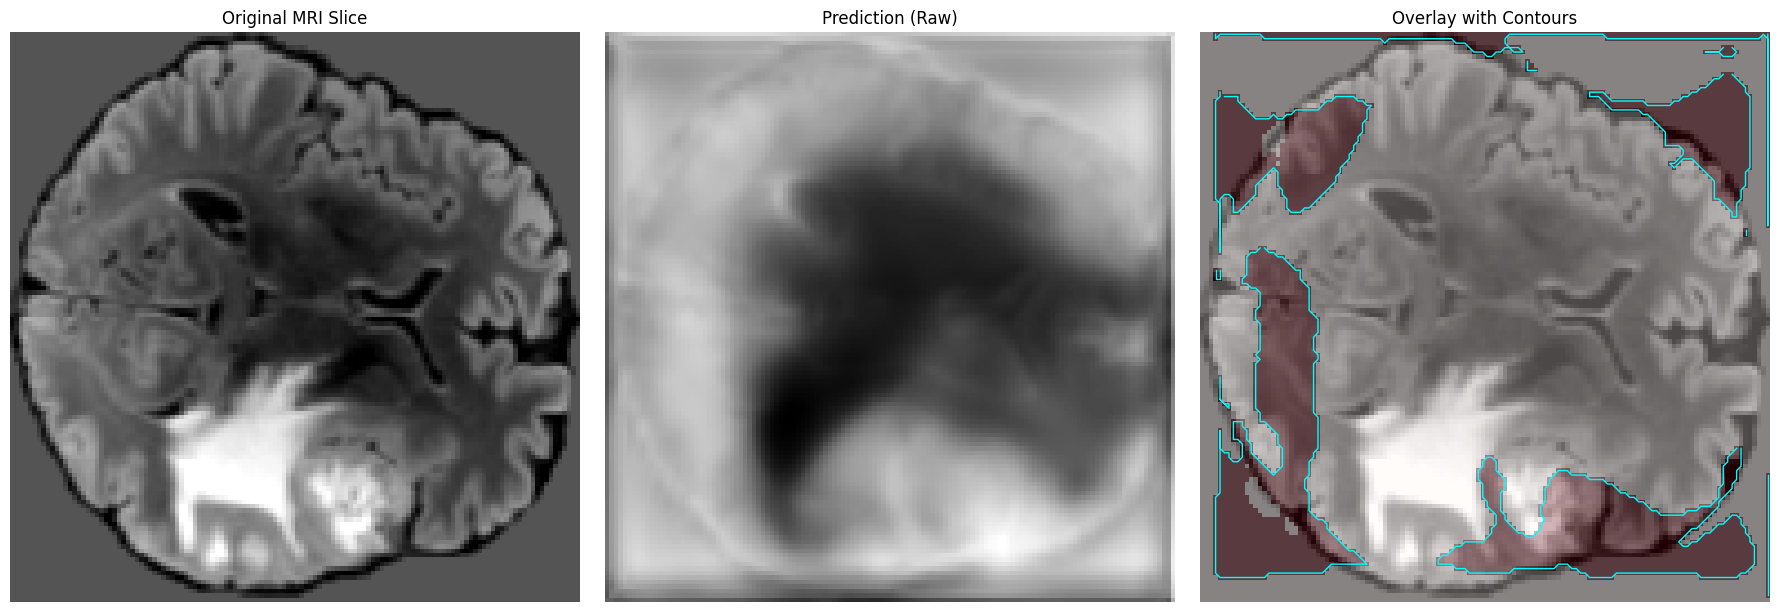

Inference:   0%|          | 1/219 [00:13<48:08, 13.25s/it]

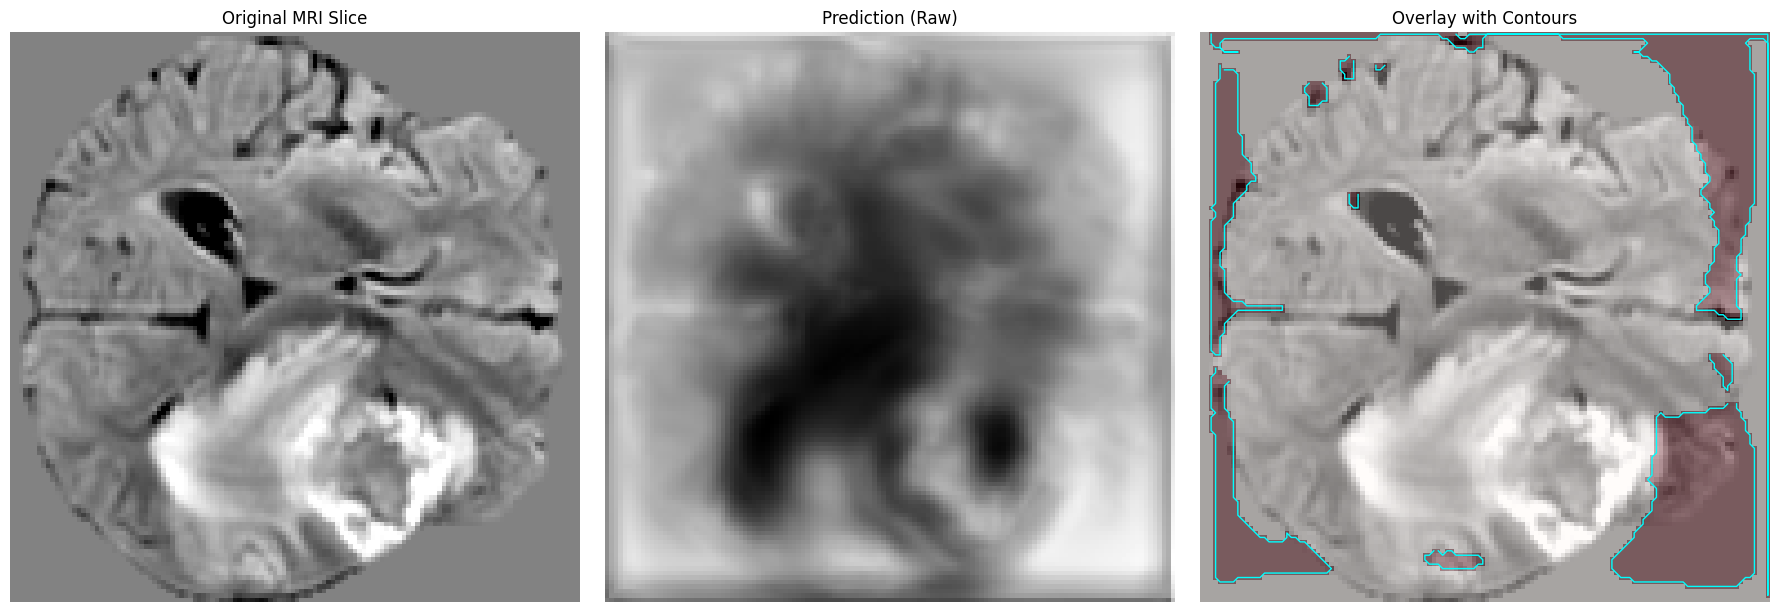

Inference:   1%|          | 2/219 [00:25<45:28, 12.57s/it]

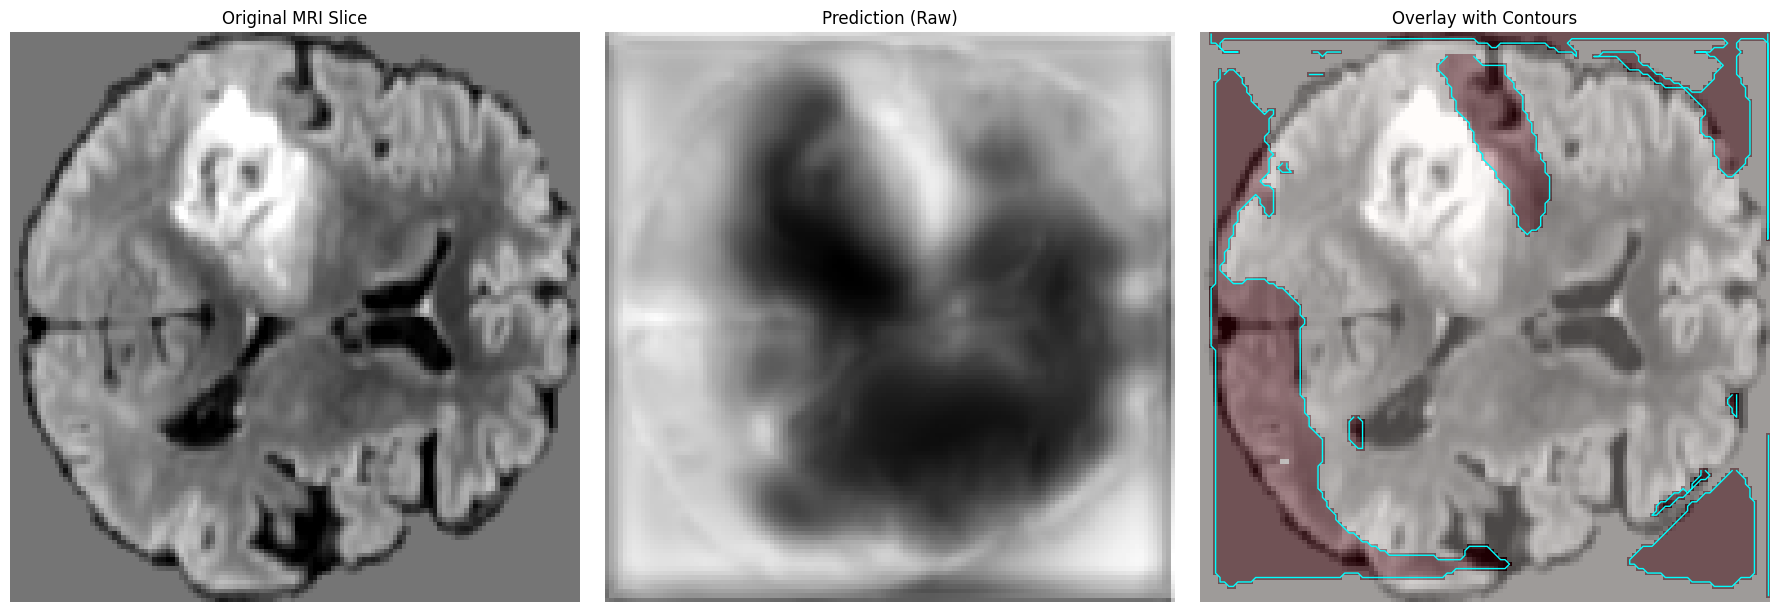

Inference:   1%|▏         | 3/219 [00:37<45:00, 12.50s/it]

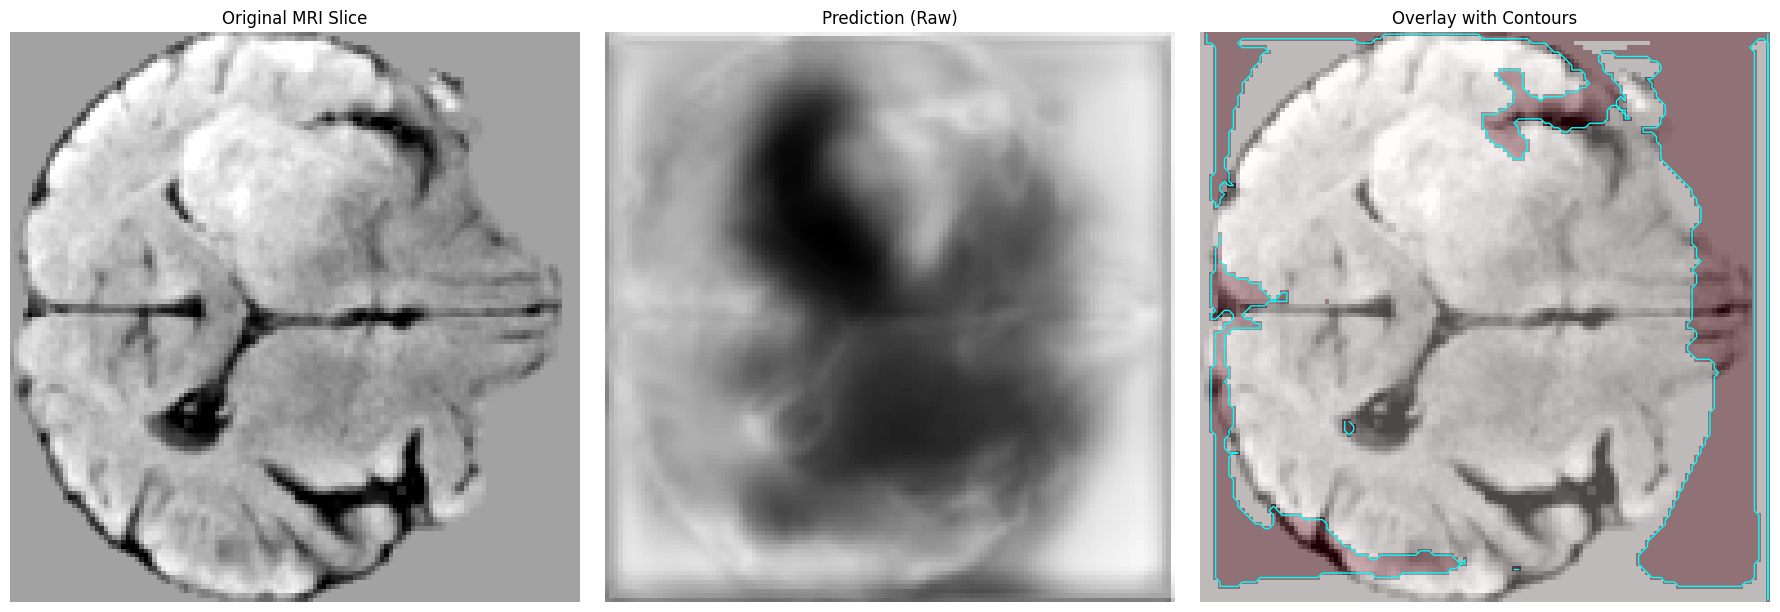

Inference:   2%|▏         | 4/219 [00:53<49:25, 13.79s/it]

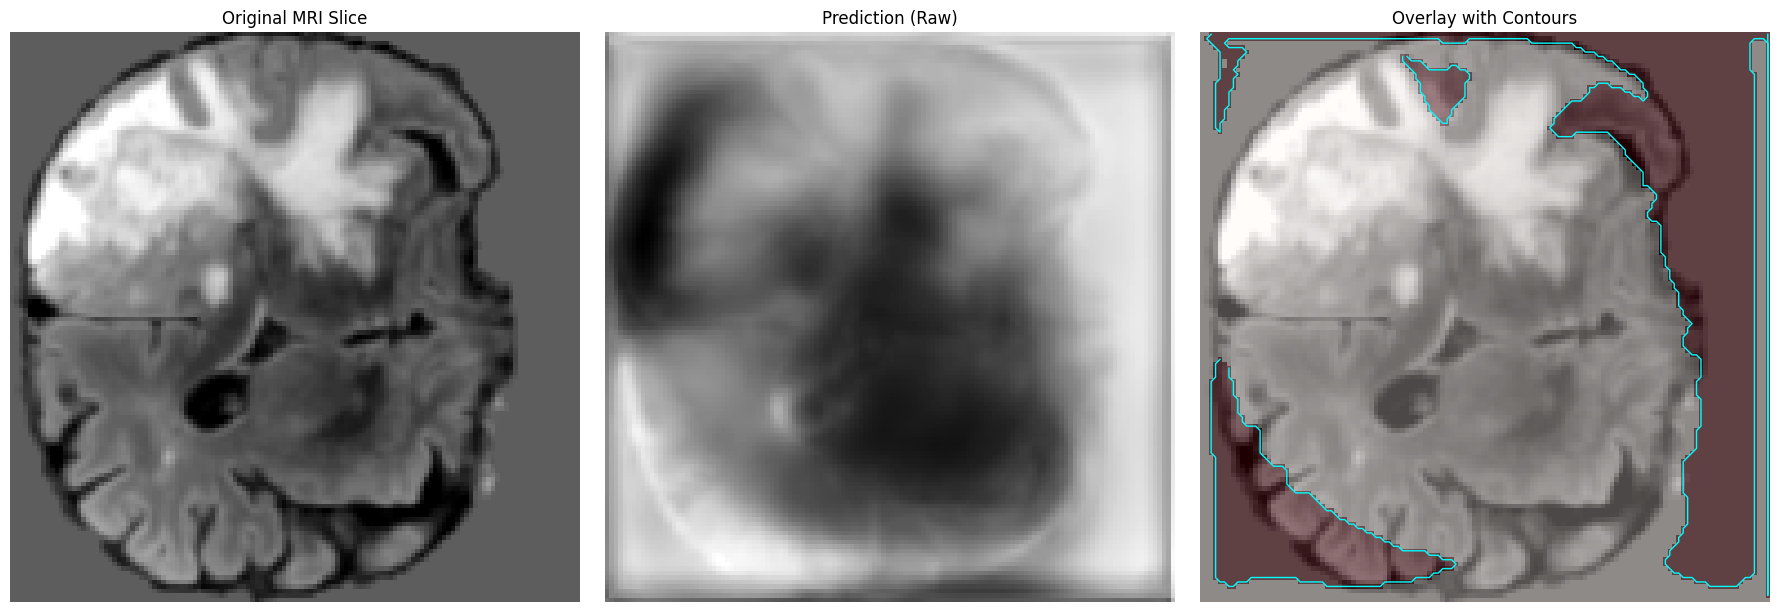

Inference:   2%|▏         | 5/219 [01:07<49:03, 13.75s/it]

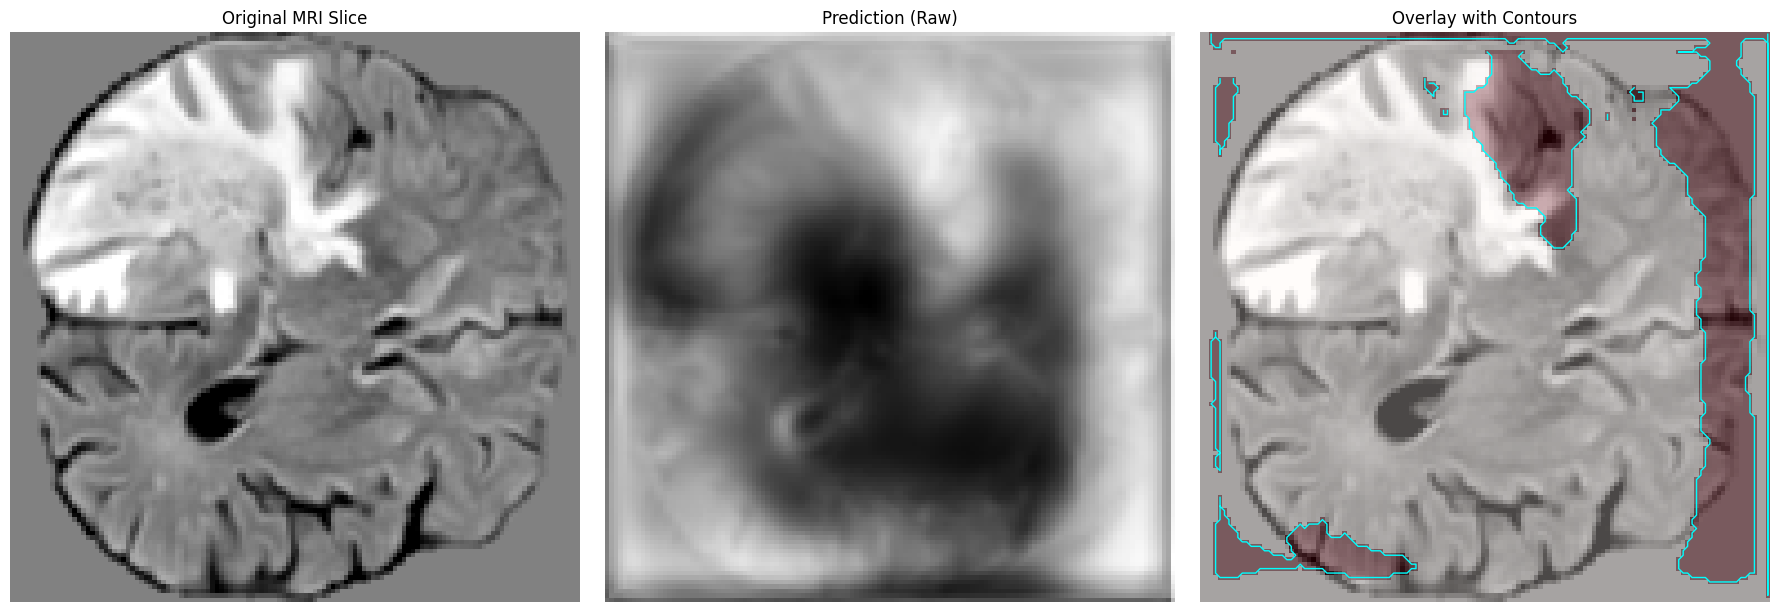

Inference:   3%|▎         | 6/219 [01:21<49:01, 13.81s/it]

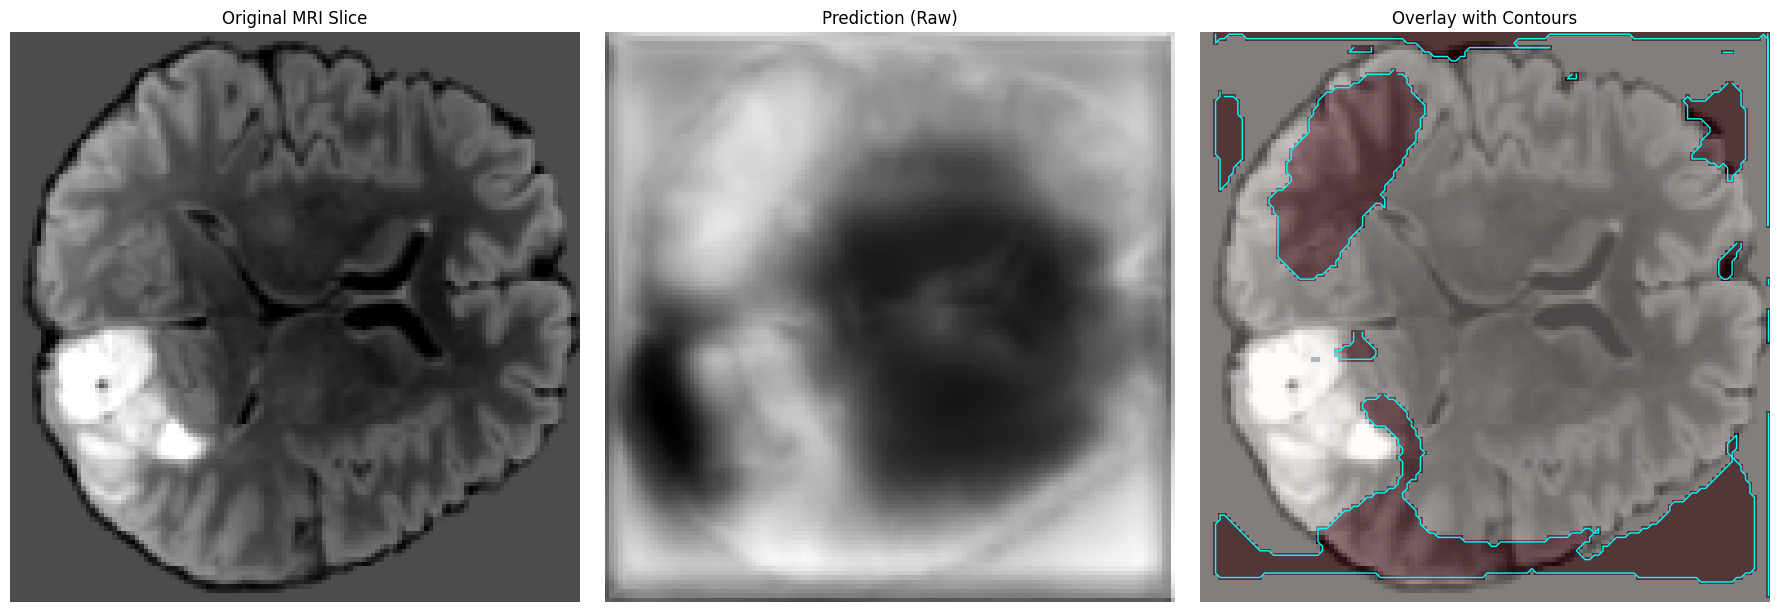

Inference:   3%|▎         | 7/219 [01:35<49:47, 14.09s/it]

Inference:   4%|▎         | 8/219 [01:48<48:25, 13.77s/it]

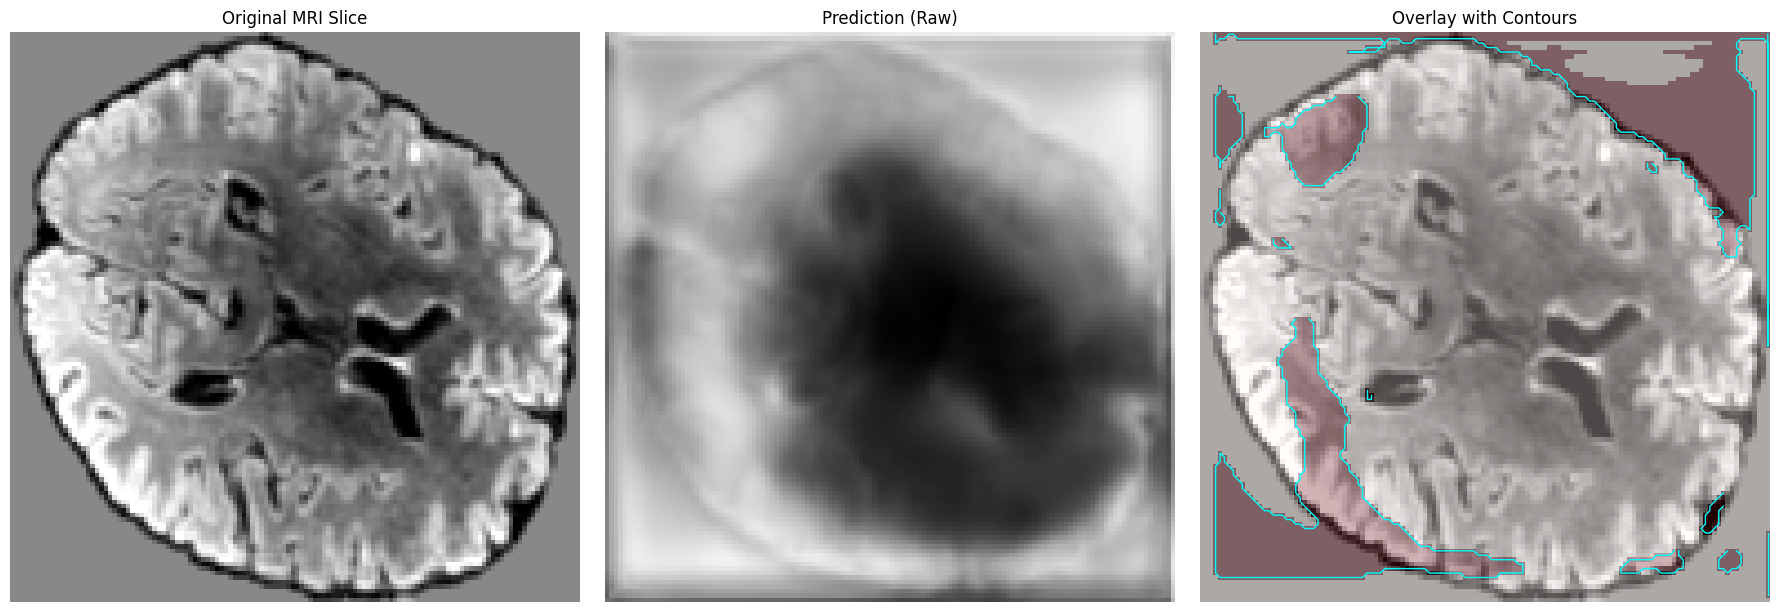

Inference:   4%|▍         | 9/219 [02:01<47:23, 13.54s/it]

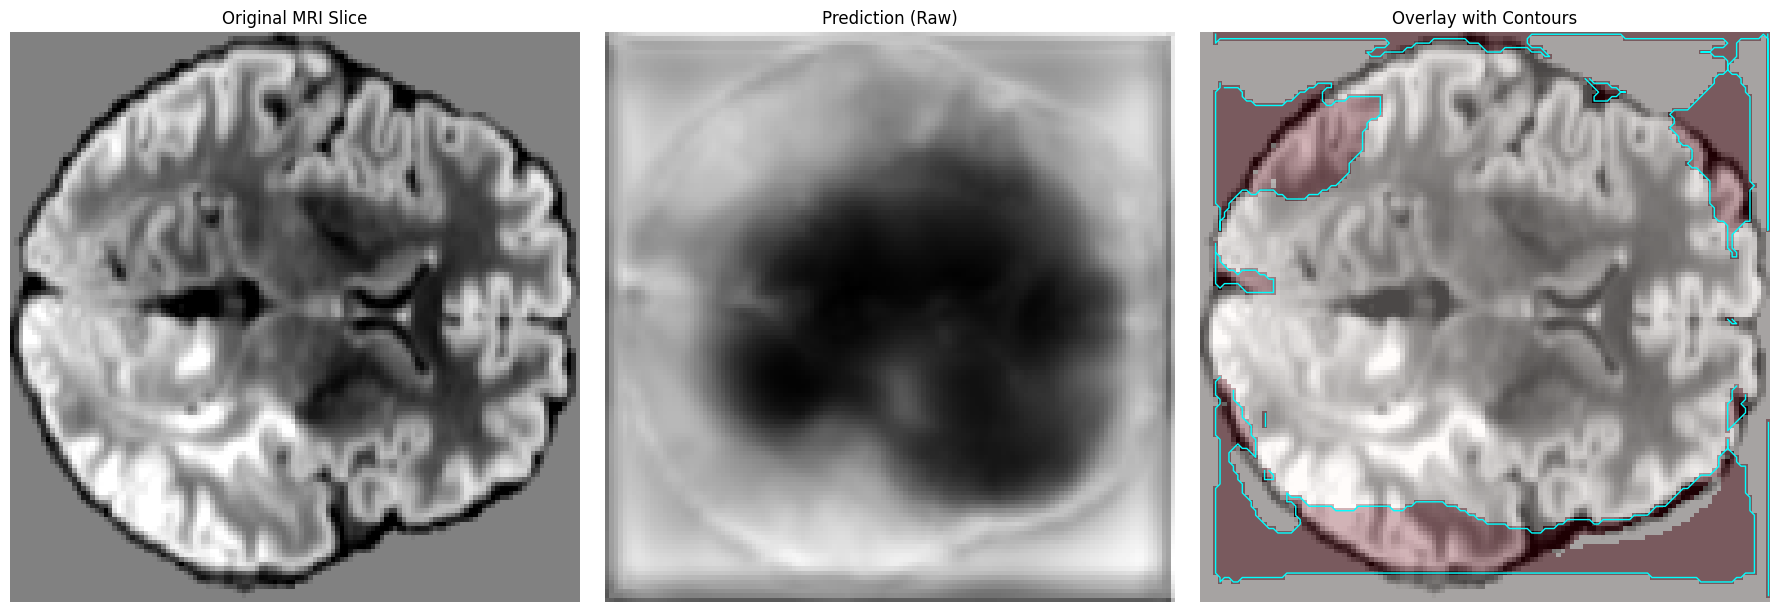

Inference:   5%|▍         | 10/219 [02:14<46:13, 13.27s/it]

Inference:   5%|▌         | 11/219 [02:28<46:50, 13.51s/it]

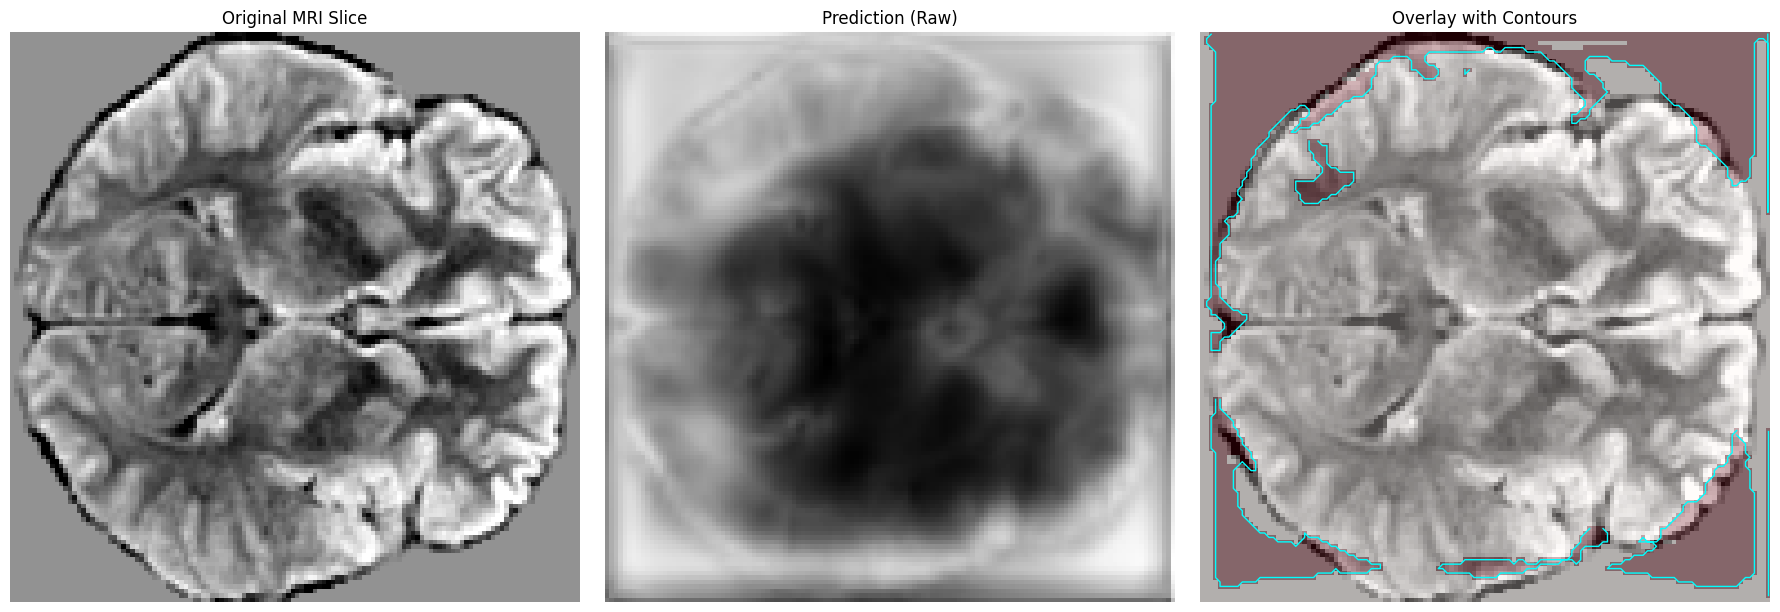

Inference:   5%|▌         | 12/219 [02:42<46:50, 13.58s/it]

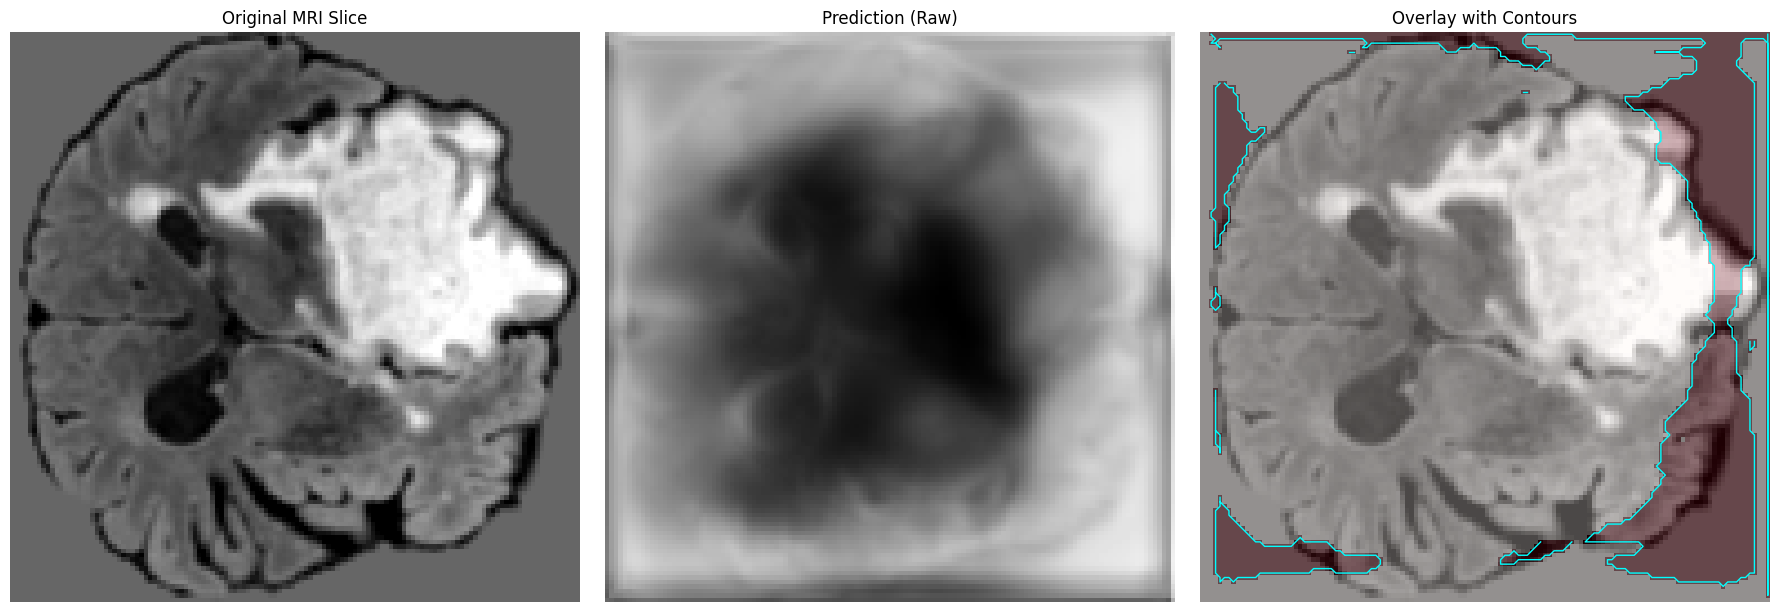

Inference:   6%|▌         | 13/219 [02:55<45:49, 13.34s/it]

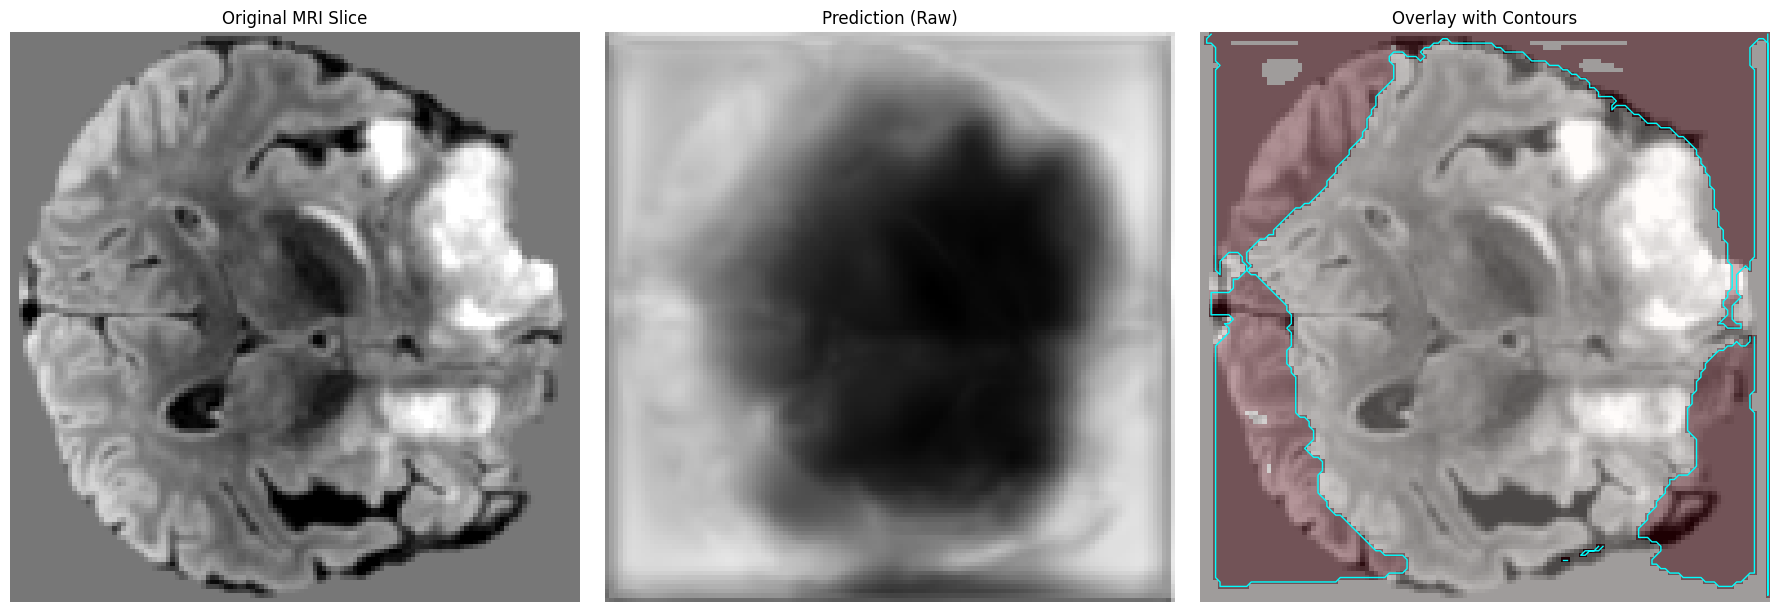

Inference:   6%|▋         | 14/219 [03:08<45:35, 13.35s/it]

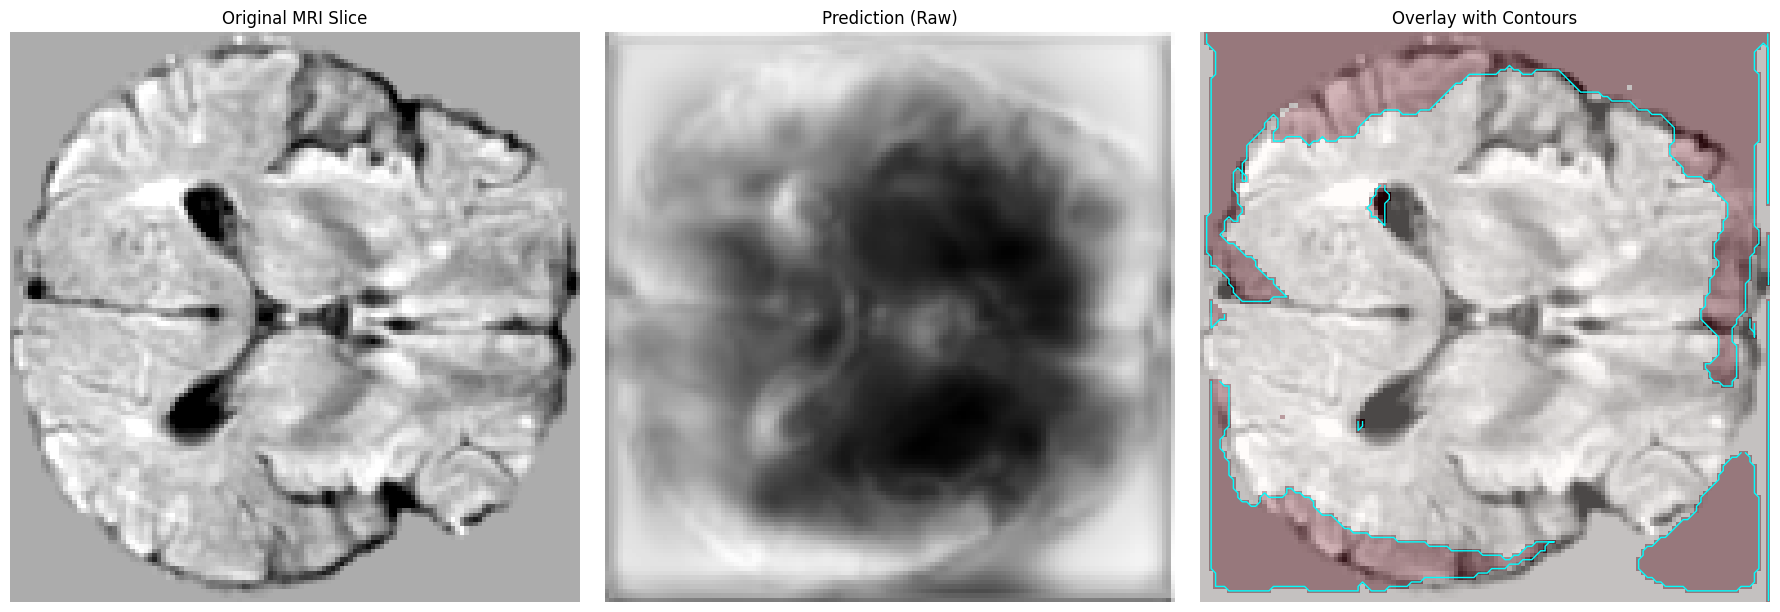

Inference:   7%|▋         | 15/219 [03:21<44:59, 13.24s/it]

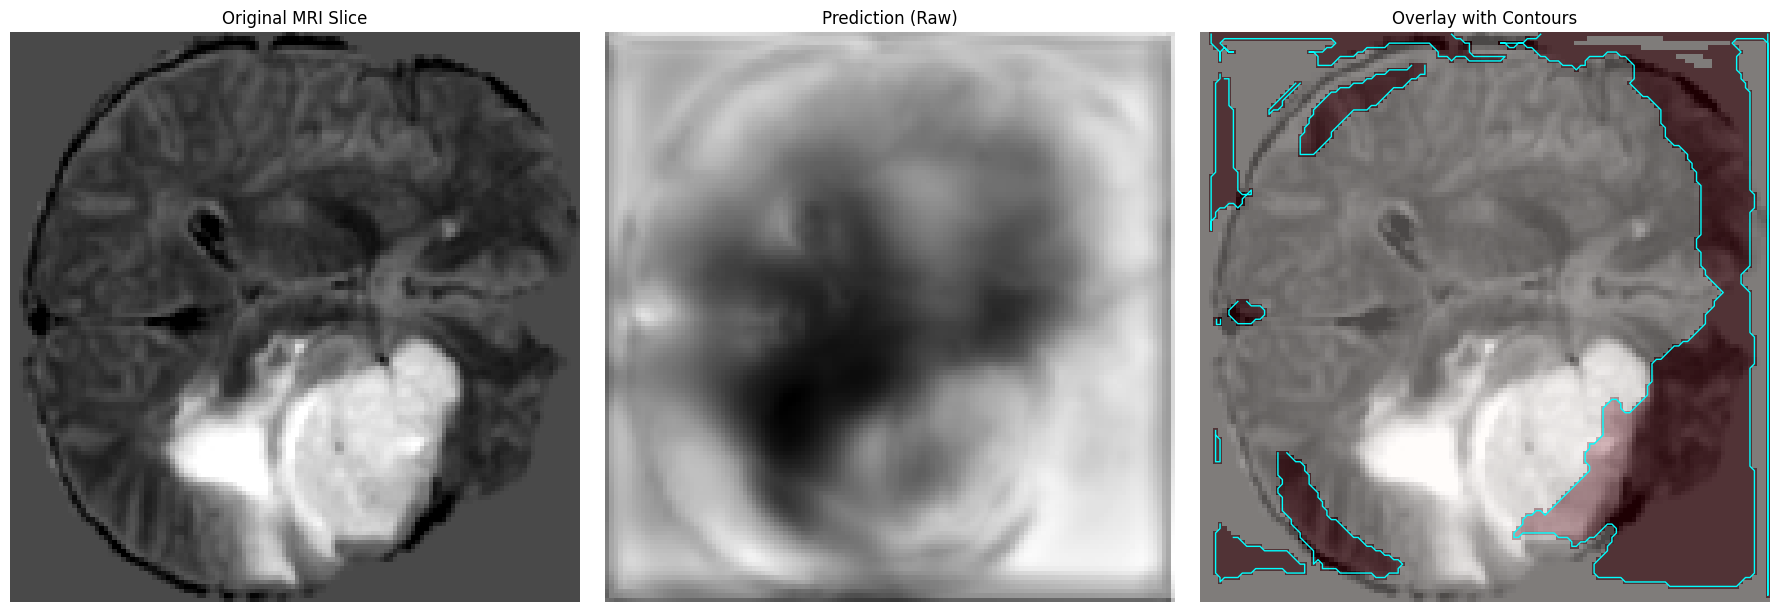

Inference:   7%|▋         | 16/219 [03:34<44:03, 13.02s/it]

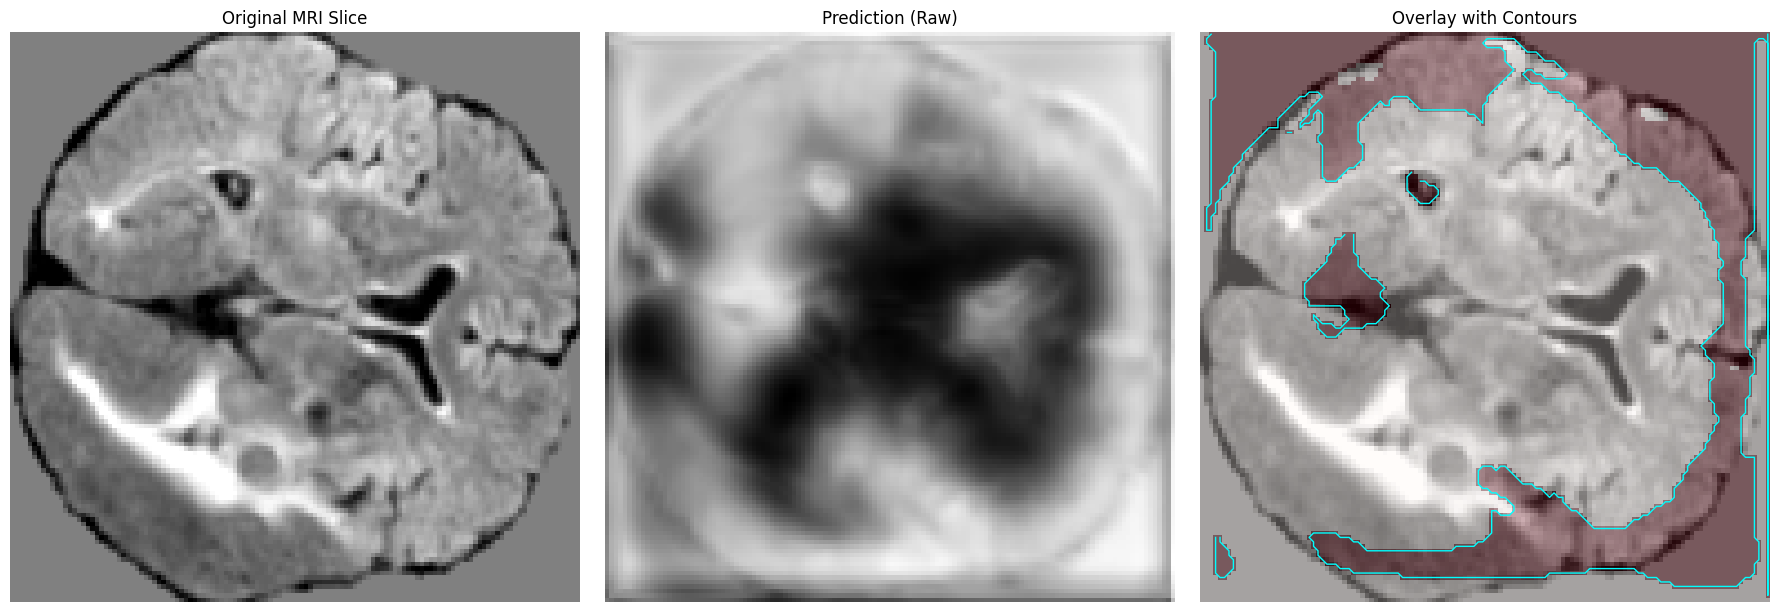

Inference:   8%|▊         | 17/219 [03:46<43:12, 12.83s/it]

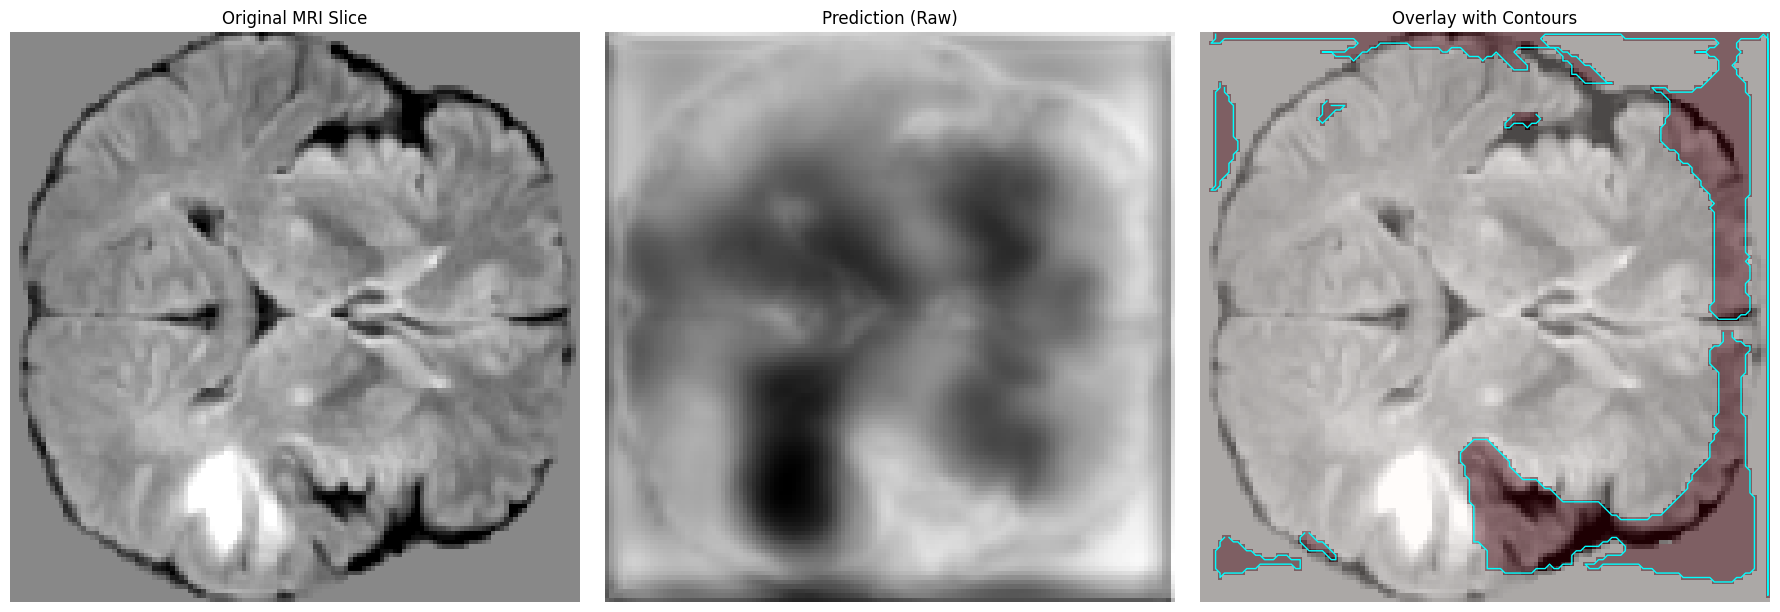

Inference:   8%|▊         | 18/219 [04:04<48:12, 14.39s/it]

Inference:   9%|▊         | 19/219 [04:19<48:22, 14.51s/it]

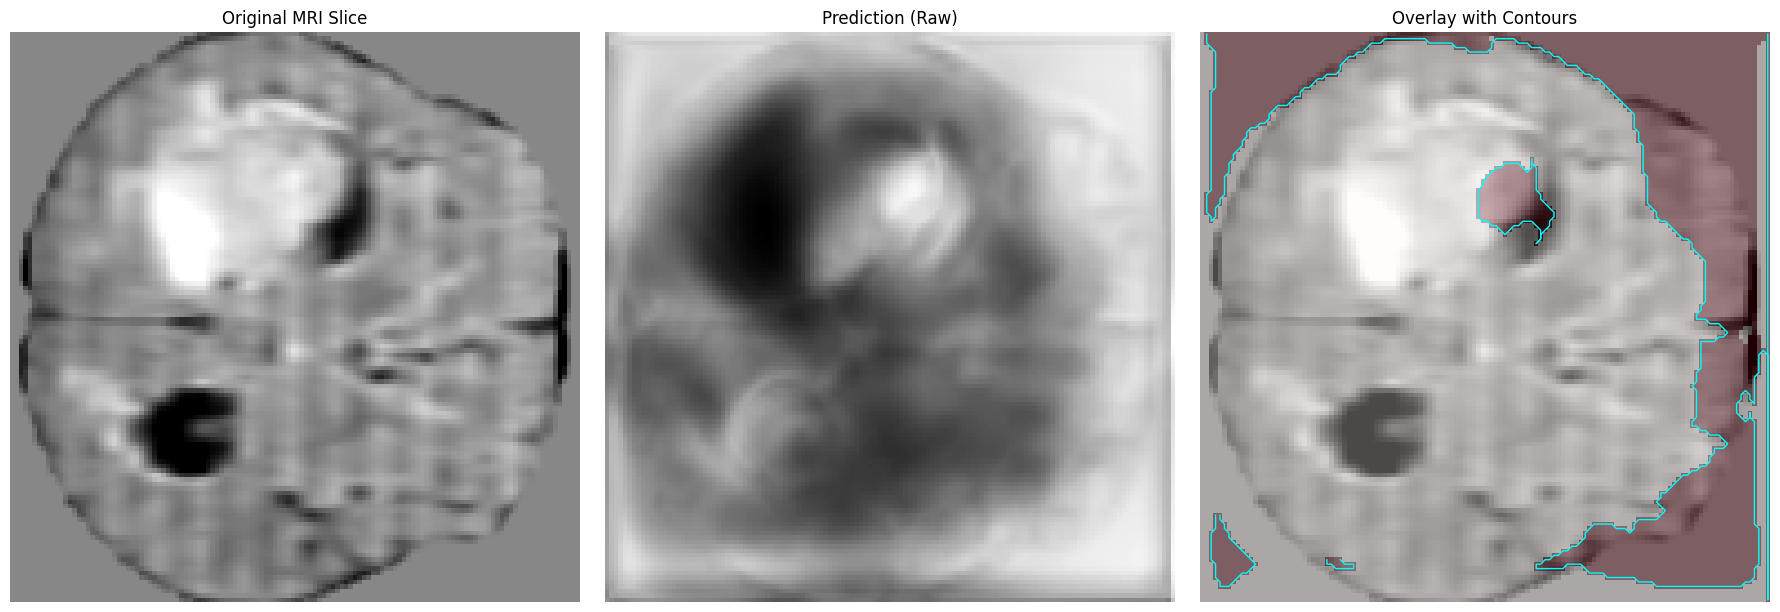

Inference:   9%|▉         | 20/219 [04:35<49:39, 14.97s/it]

Inference:  10%|▉         | 21/219 [04:50<50:00, 15.15s/it]

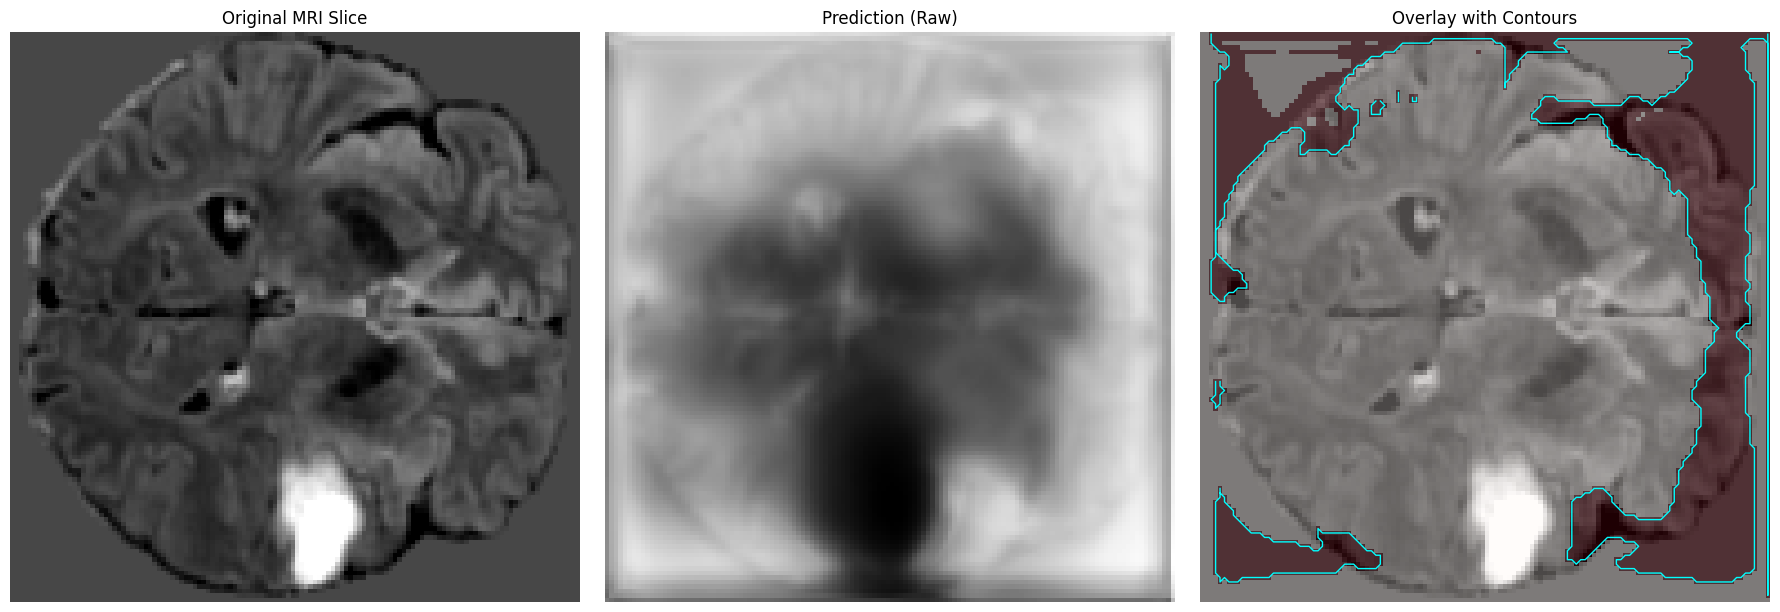

Inference:  10%|█         | 22/219 [05:07<51:19, 15.63s/it]

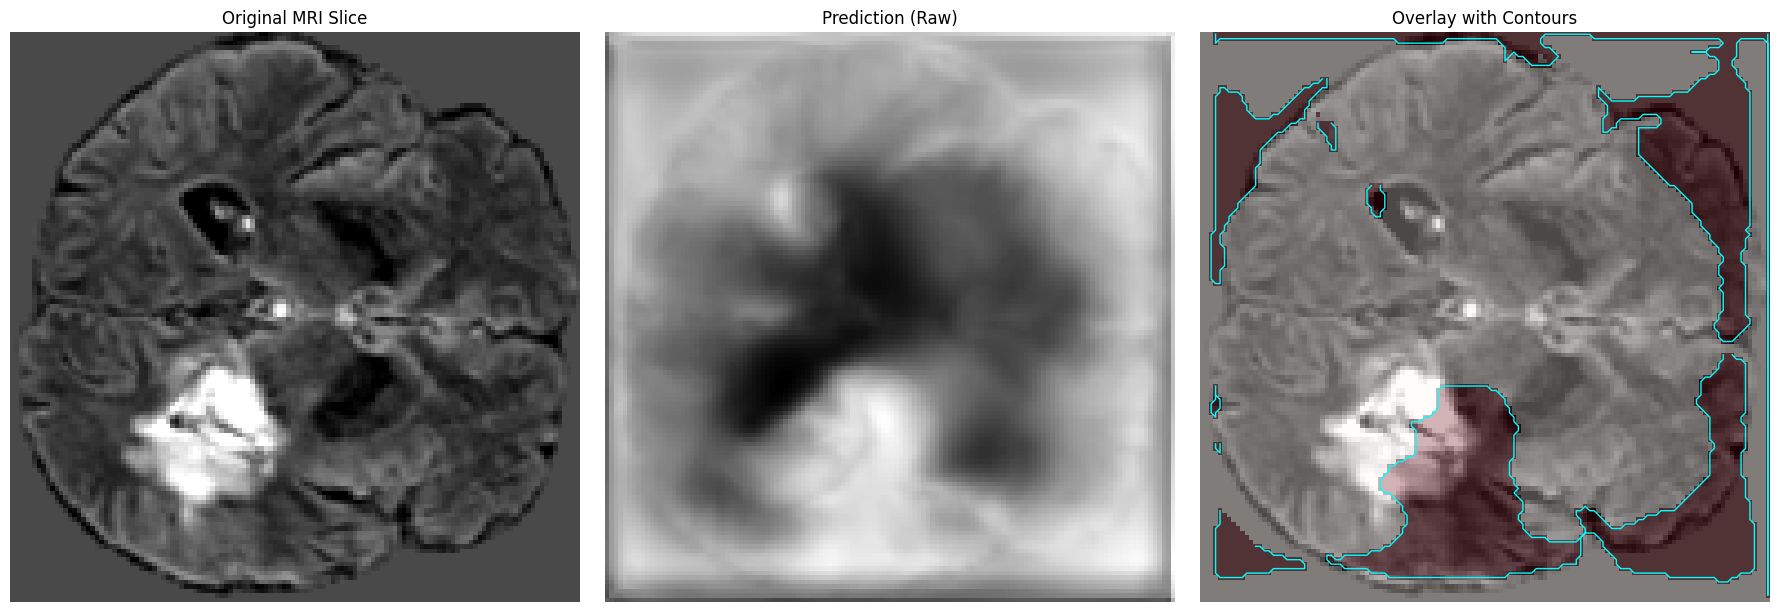

Inference:  11%|█         | 23/219 [05:25<53:26, 16.36s/it]

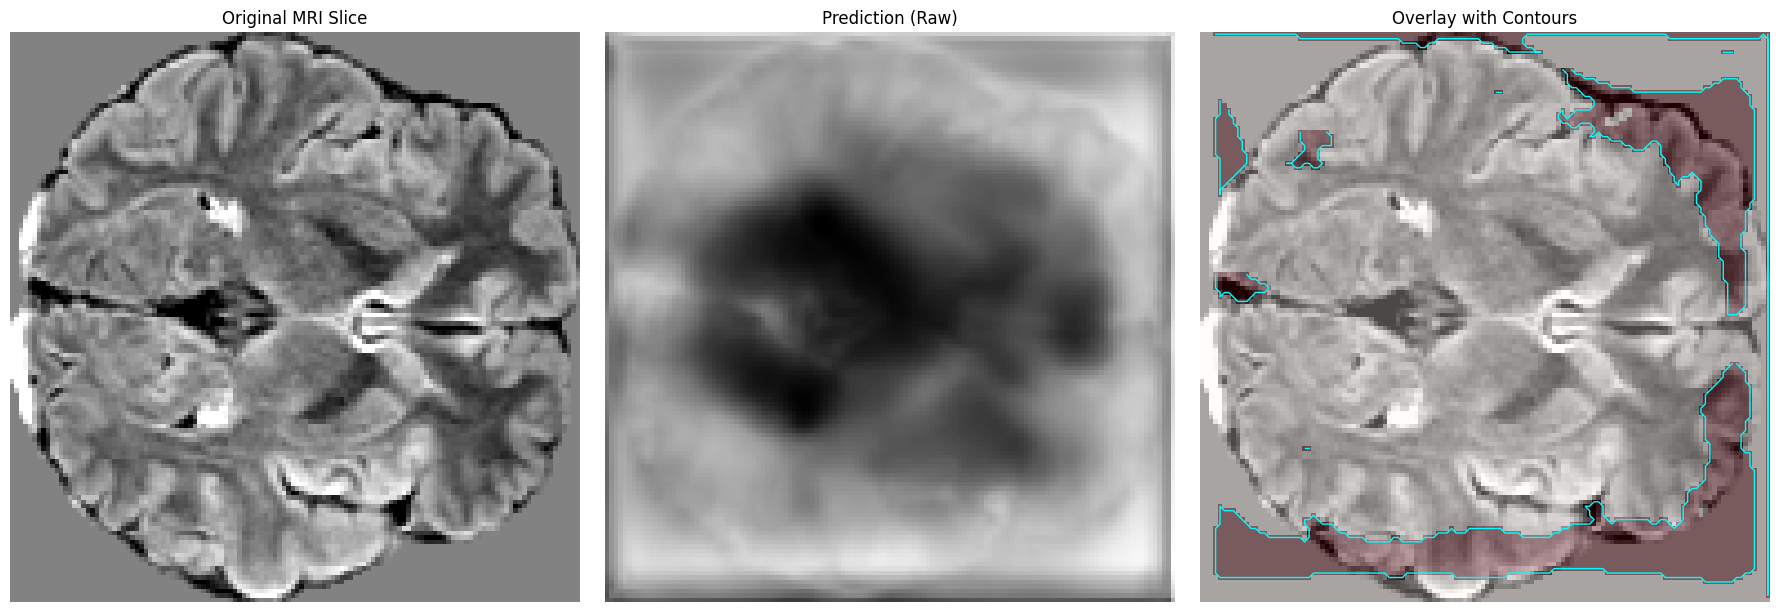

Inference:  11%|█         | 24/219 [05:42<53:23, 16.43s/it]

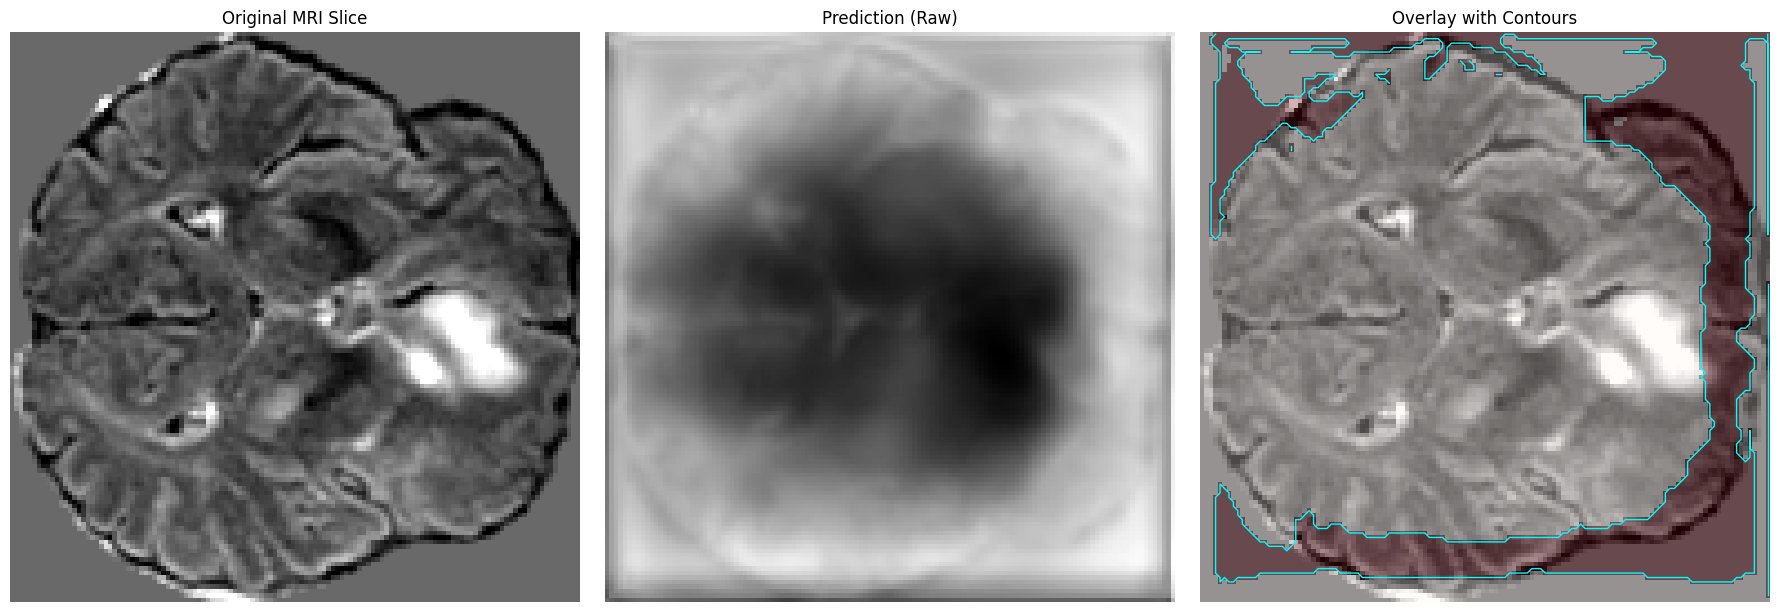

Inference:  11%|█▏        | 25/219 [05:58<52:50, 16.34s/it]

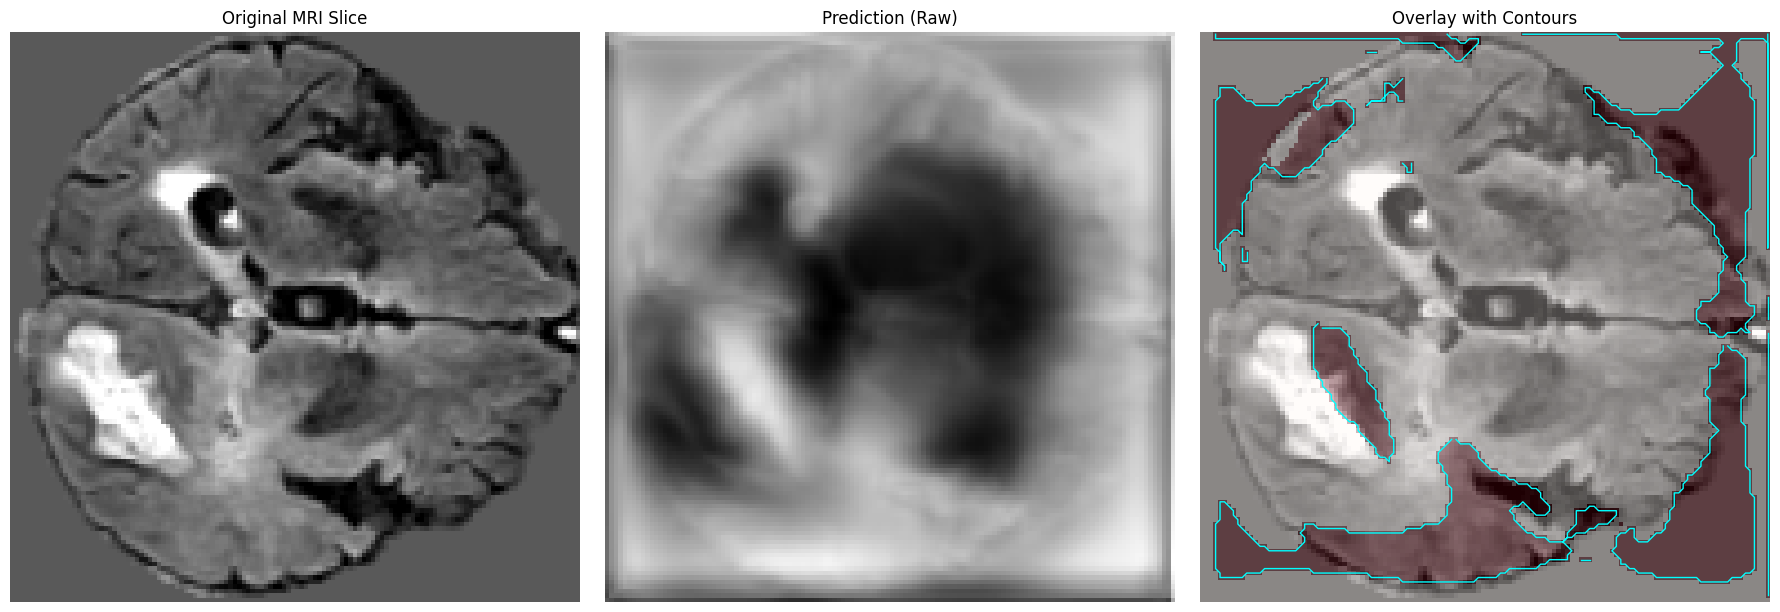

Inference:  12%|█▏        | 26/219 [06:13<50:54, 15.83s/it]

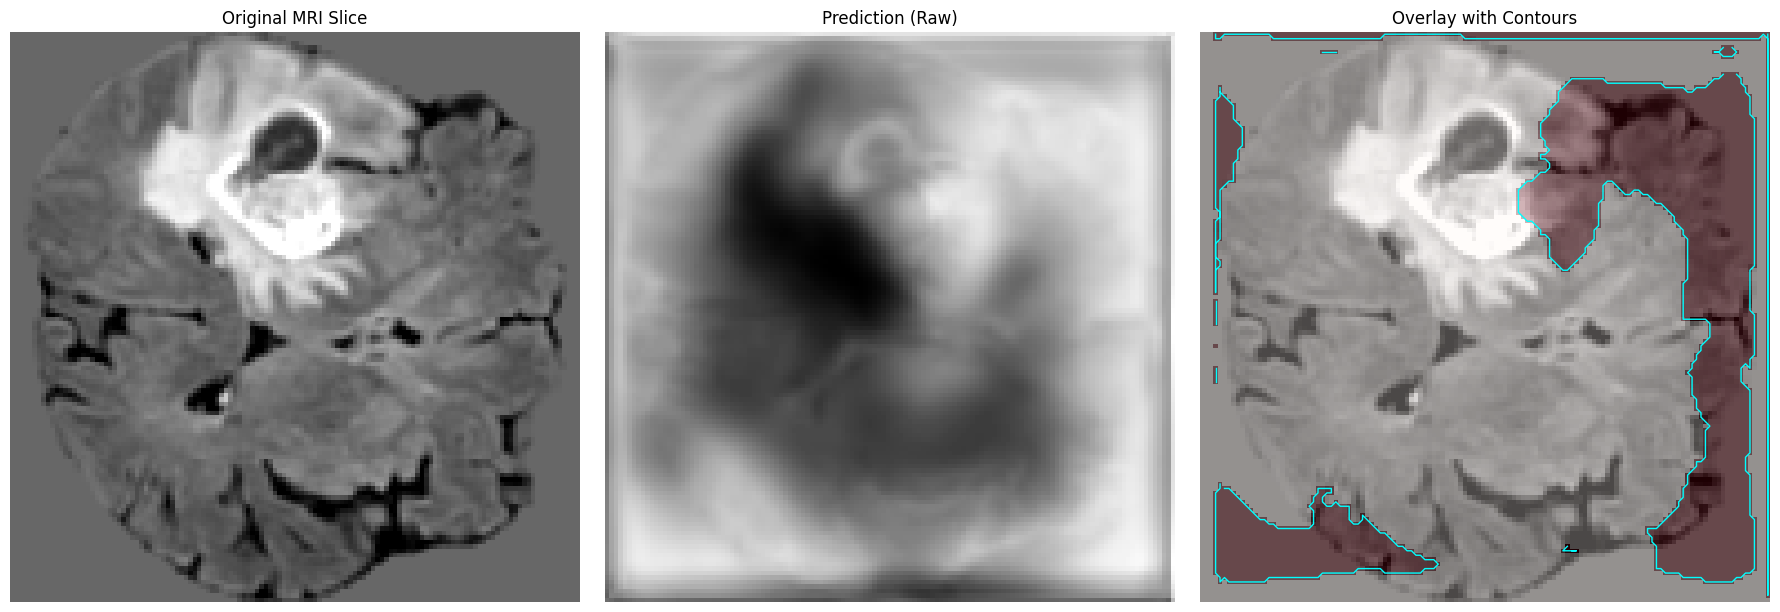

Inference:  12%|█▏        | 27/219 [06:26<48:41, 15.22s/it]

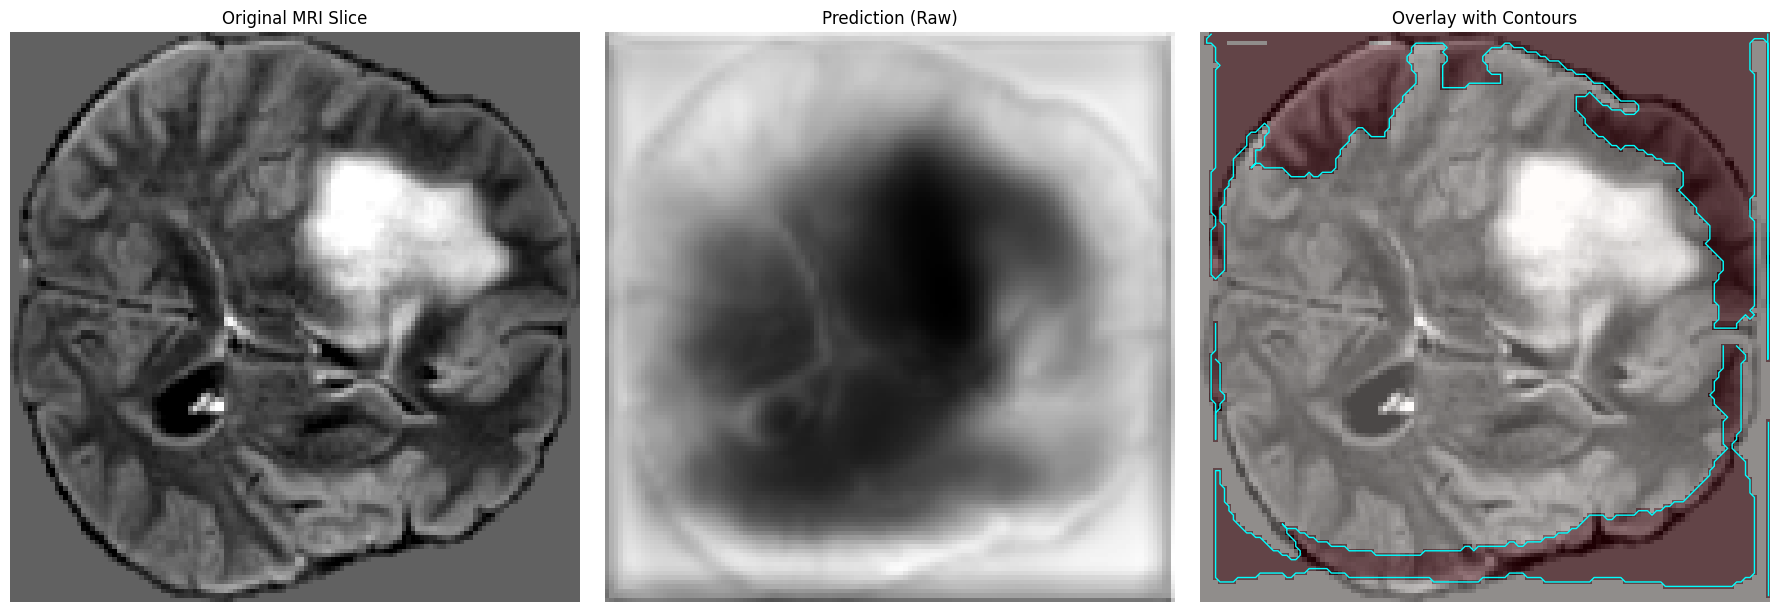

Inference:  13%|█▎        | 28/219 [06:41<48:18, 15.18s/it]

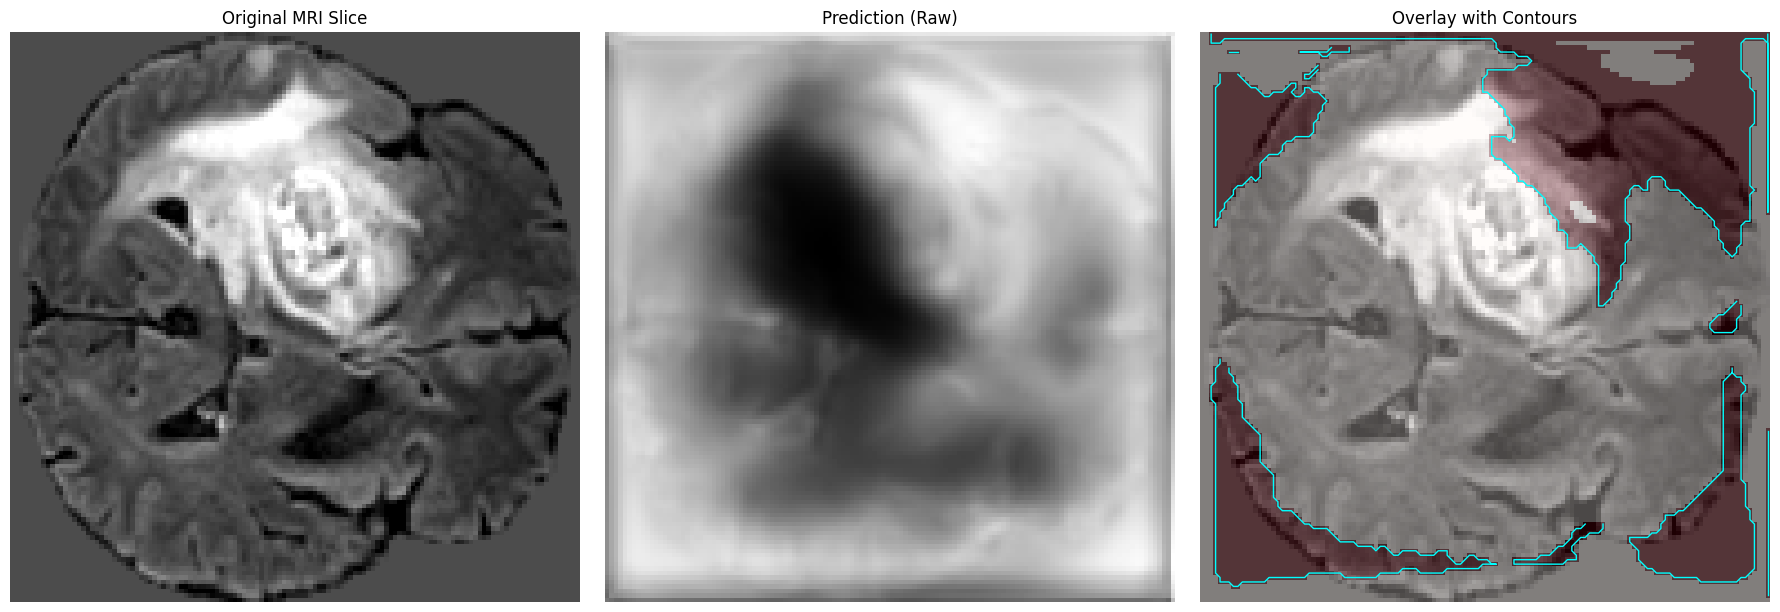

Inference:  13%|█▎        | 29/219 [07:03<46:15, 14.61s/it]


KeyboardInterrupt: 

In [ ]:
from torch.nn.functional import interpolate
from monai.transforms import LoadImage

# Set model to eval
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

viz_cases = []
loader = LoadImage(image_only=True)

for i, batch in enumerate(tqdm(val_files, desc="Inference")):
    try:
        # Load and preprocess image
        img_np = loader(batch["image"])  # shape: [H,W,D,4]
        original_data = np.moveaxis(img_np, -1, 0)  # shape: [4,H,W,D]

        # Transform into tensor
        data = val_transforms({"image": batch["image"]})
        img_tensor = data["image"].unsqueeze(0).to(device)  # shape: [1,4,H,W,D]

        # Predict and upsample if needed
        with torch.no_grad():
            pred = torch.sigmoid(model(img_tensor))
            if pred.shape[-1] != img_tensor.shape[-1]:
                pred = interpolate(pred, size=img_tensor.shape[2:], mode="trilinear", align_corners=False)

            pred_np = pred.squeeze().cpu().numpy()  # shape: [H,W,D]

        # Mid slice
        mid_slice = pred_np.shape[2] // 2
        pred_slice = pred_np[:, :, mid_slice]
        # (We change values from 0 to 3 before running to expereince the outcomes of each of the four modalities of MRI Scan)
        original_slice = original_data[3, :, :, mid_slice]  # T1 modality assumed 

        # Threshold + contours
        mask_bin = (pred_slice > 0.5).astype(np.uint8)
        # Keep only largest connected component/This improves clarity of overlays by removing specks.
        num_labels, labels_im = cv2.connectedComponents(mask_bin)
        if num_labels > 1:
            largest = 1 + np.argmax([np.sum(labels_im == i) for i in range(1, num_labels)])
            mask_bin = (labels_im == largest).astype(np.uint8)

        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Visual display
        plt.figure(figsize=(18, 6))

        # Original MRI Scan
        plt.subplot(1, 3, 1)
        vmin, vmax = np.percentile(original_slice, [1, 99])
        plt.imshow(original_slice, cmap="gray", vmin=vmin, vmax=vmax)
        plt.title("Original MRI Slice")
        plt.axis("off")

        # Prediction - Model Prediction of tumor segmentation on MRI Scan
        plt.subplot(1, 3, 2)
        plt.imshow(pred_slice, cmap="gray")
        plt.title("Prediction (Raw)")
        plt.axis("off")

        # Overlay and boundary on the tumour to make it more visible
        plt.subplot(1, 3, 3)
        plt.imshow(original_slice, cmap="gray", vmin=vmin, vmax=vmax)
        plt.imshow(mask_bin, cmap="Reds", alpha=0.3)
        for cnt in contours:
            plt.plot(cnt[:, 0, 0], cnt[:, 0, 1], color="cyan", linewidth=1)
        plt.title("Overlay with Contours")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        # Save for later multi-modal display
        if i < 3:
            viz_cases.append({
                "filename": batch["image"],
                "original": original_data,
                "prediction": pred_np,
                "mid_slice": mid_slice
            })

    except Exception as e:
        print(f"Error in case {i} ({batch['image']}): {str(e)[:200]}")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from monai.transforms import Activations, AsDiscrete

# Ensure model is in evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Post-processing transforms
sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)

# Inference and visualization
num_cases = 3  # Number of cases to visualize
visualized = 0

for batch in tqdm(val_loader, desc="Visualizing predictions"):
    with torch.no_grad():
        inputs = batch["image"].to(device)  # [1, 4, H, W, D]
        filename = batch["image_meta_dict"]["filename_or_obj"][0]
        original = inputs.cpu().numpy().squeeze(0)  # [4, H, W, D]

        # Forward pass
        output = model(inputs)  # logits
        pred = sigmoid(output)
        pred_bin = post_pred(pred).cpu().numpy().squeeze()  # [H, W, D]

    # Loop over all 4 modalities
    for modality_idx in range(4):
        modality_vol = original[modality_idx]
        mid_slice = modality_vol.shape[-1] // 2

        image_slice = modality_vol[:, :, mid_slice]
        pred_slice = pred_bin[:, :, mid_slice]

        # Create binary mask
        mask_bin = (pred_slice > 0.5).astype(np.uint8)
        contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Visualizations
        plt.figure(figsize=(18, 5))

        # Raw modality slice
        plt.subplot(1, 3, 1)
        vmin, vmax = np.percentile(image_slice, [1, 99])
        plt.imshow(image_slice, cmap="gray", vmin=vmin, vmax=vmax)
        plt.title(f"Original Modality {modality_idx}")
        plt.axis("off")

        # Prediction only
        plt.subplot(1, 3, 2)
        plt.imshow(pred_slice, cmap="gray")
        plt.title("Prediction (Raw)")
        plt.axis("off")

        # Overlay
        plt.subplot(1, 3, 3)
        plt.imshow(image_slice, cmap="gray", vmin=vmin, vmax=vmax)
        plt.imshow(mask_bin, cmap="Reds", alpha=0.3)
        for cnt in contours:
            plt.plot(cnt[:, 0, 0], cnt[:, 0, 1], color="cyan", linewidth=1)
        plt.title("Overlay with Tumor Contour")
        plt.axis("off")

        plt.suptitle(f"Case: {filename.name}, Modality {modality_idx}")
        plt.tight_layout()
        plt.show()

    visualized += 1
    if visualized >= num_cases:
        break


In [ ]:
from monai.transforms import LoadImage
viz_cases = []
loader = LoadImage(image_only=True)
def show_modalities(case, pred_slice):
    modalities = ["T1", "T1c", "T2", "FLAIR"]
    plt.figure(figsize=(15, 10))

    for i in range(4):  # for each MRI modality
        # Top row: original
        plt.subplot(2, 4, i + 1)
        img = case["original"][i, :, :, case["mid_slice"]]
        vmin, vmax = np.percentile(case["original"][i], [1, 99])
        plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
        plt.title(f"{modalities[i]} Original")
        plt.axis("off")

        # Bottom row: overlay
        plt.subplot(2, 4, i + 5)
        plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
        plt.imshow(pred_slice, cmap="jet", alpha=0.4, vmin=0, vmax=1)
        plt.title(f"{modalities[i]} + Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Trigger on first visualized case
if viz_cases:
    print(f"\nMulti-Modal Breakdown for Case: {viz_cases[0]['filename']}")
    show_modalities(
        viz_cases[0],
        viz_cases[0]["prediction"][:, :, viz_cases[0]["mid_slice"]]
    )
else:
    print("No valid visualization cases found.")

No valid visualization cases found.
